In [16]:
from __future__ import division

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
import scipy.stats as sp
import Pycluster as pc

%matplotlib inline

In [32]:
# DNAInfo Data
ny_data = r'NYC_Similarity_Silhouette.geojson'
#ny_data = r'C:\Users\Dan\OneDrive\Draw-Your-Neighborhood-master\NYC_raw_wgs84.geojson'
ny_nhoods = gpd.read_file(ny_data)

# Set the crs of the input geojson
ny_nhoods.crs = {'init': 'epsg:32118'}

ny_nhoods.head()

# New York City borough boundaries.
nyc = gpd.read_file(r'C:\Users\djl543\OneDrive\Draw-Your-Neighborhood-master\NYC.shp')

# Project to EPSG:32118 - New York Long Island, NAD83-based projection in metres.
nyc = nyc.to_crs({'init':'epsg:32118'})

In [33]:
# Calculate the geometric centroid of each record
ny_nhoods['centroid'] = ny_nhoods['geometry'].centroid

# Group the data
ny_grp = ny_nhoods.groupby('nhood')

# Now calulate 
n_hood_centroids = {}
count = 0
for nid, data in ny_grp:
    centroids = []
    for row in data.iterrows():
        centroids.append(np.array(row[1]['centroid']))
    ncenter, nmask = pc.clustercentroids(centroids,method='m')
    n_hood_centroids[count] = [nid,shapely.geometry.Point(ncenter[0]),len(data)]
    count+=1

# Finally, put the median center information and counts of drawings into a new geopandas dataframe
n_centroids = gpd.GeoDataFrame(n_hood_centroids).transpose()
# Name the columns
n_centroids.columns = ["neighborhood","geometry","count"]
# Add a rank column based upon the number of drawings
n_centroids['rank'] = n_centroids['count'].rank(ascending=False)
# Set the CRS of n-centroids
n_centroids.crs = {'init': 'epsg:32118'}

n_centroids.head()

,neighborhood,geometry,count,rank
0,Allerton,POINT (311643.6932491333 77597.82904214269),104,84.5
1,Alphabet City,POINT (301709.2279281036 62002.55728907162),140,68.0
2,Annadale,POINT (284646.1229115428 41711.41527360405),94,88.5
3,Arden Heights,POINT (284048.4499701513 43075.44375345457),77,106.5
4,Arrochar,POINT (293869.7801887682 47913.39909703079),40,162.0


In [34]:
# Do a spatial join of nyc on n_centroids (point in polygon)
n_centroids = gpd.sjoin(n_centroids, nyc, how="left", op='within')

# Manhattan Neighborhoods

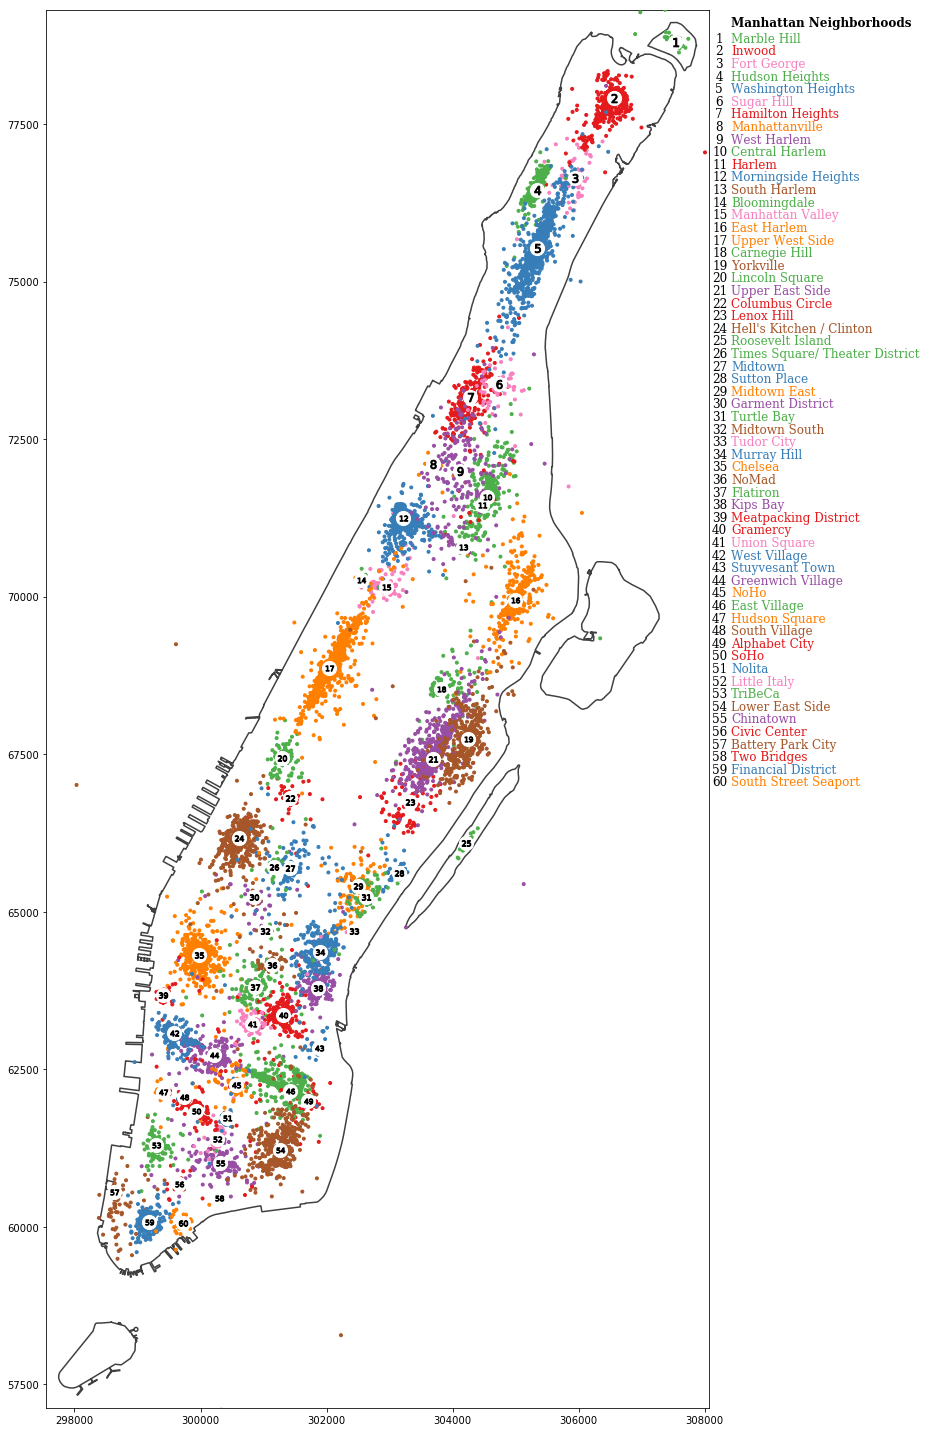

In [31]:
# Select just manhattan as a basemap shape
nyc = nyc[nyc['BoroName'] == 'Manhattan']

# Now get the polygon exteriors that I want to map (I first figured out that they were in the given positions)
cnt =0
lines = []
for i in list(nyc['geometry'].boundary)[0].geoms:
    if cnt in [6,25,27,28,30]:
        lines.append(i)
    cnt+=1

# Let's try mapping all of the centroids of each neighbourhood.
fig, ax = plt.subplots(1,figsize=(16,20))

# Get just manhattan drawings
manhattan = ny_nhoods[ny_nhoods['BoroName']=='Manhattan']

centroids = []
for idx,row in manhattan.iterrows():
    centroids.append((str(row['nhood']),float(row['centroid'].x),float(row['centroid'].y)))
dt = [('nhood','a32'),('x', float), ('y', float)]
centroids = np.asarray(centroids,dtype=dt)

# hard code a bunch of neighbourhood colours
colours = {'Alphabet City': '#e41a1c',
           'Battery Park City': '#a65628',
           'Bloomingdale': '#4daf4a',
           'Carnegie Hill': '#4daf4a',
           'Central Harlem': '#4daf4a',
           'Chelsea': '#ff7f00',
           'Chinatown': '#984ea3',
           'Civic Center': '#e41a1c',
           'Columbus Circle': '#e41a1c',
           'East Harlem': '#ff7f00',
           'East Village': '#4daf4a',
           'Financial District': '#377eb8',
           'Flatiron': '#4daf4a',
           'Fort George': '#f781bf',
           'Garment District': '#984ea3',
           'Gramercy': '#e41a1c',
           'Greenwich Village': '#984ea3',
           'Hamilton Heights': '#e41a1c',
           'Harlem': '#e41a1c',
           'Hell\'s Kitchen / Clinton': '#a65628',
           'Hudson Heights': '#4daf4a',
           'Hudson Square': '#ff7f00',
           'Inwood': '#e41a1c',
           'Kips Bay': '#984ea3',
           'Lenox Hill': '#e41a1c',
           'Lincoln Square': '#4daf4a',
           'Little Italy': '#f781bf',
           'Lower East Side': '#a65628',
           'Manhattan Valley': '#f781bf',
           'Manhattanville': '#ff7f00',
           'Marble Hill': '#4daf4a',
           'Meatpacking District': '#e41a1c',
           'Midtown': '#377eb8',
           'Midtown East': '#ff7f00',
           'Midtown South': '#a65628',
           'Morningside Heights': '#377eb8',
           'Murray Hill': '#377eb8',
           'NoHo': '#ff7f00',
           'NoMad': '#a65628',
           'Nolita': '#377eb8',
           'Roosevelt Island': '#4daf4a',
           'SoHo': '#e41a1c',
           'South Harlem': '#a65628',
           'South Street Seaport': '#ff7f00',
           'South Village': '#a65628',
           'Stuyvesant Town': '#377eb8',
           'Sugar Hill': '#f781bf',
           'Sutton Place': '#377eb8',
           'Times Square/ Theater District': '#4daf4a',
           'TriBeCa': '#4daf4a',
           'Tudor City': '#f781bf',
           'Turtle Bay': '#4daf4a',
           'Two Bridges': '#e41a1c',
           'Union Square': '#f781bf',
           'Upper East Side': '#984ea3',
           'Upper West Side': '#ff7f00',
           'Washington Heights': '#377eb8',
           'West Harlem': '#984ea3',
           'West Village': '#377eb8',
           'Yorkville': '#a65628'}

# Add x and y values as columns to median centres dataframe
n_centroids["x"] = n_centroids.centroid.map(lambda p: p.x)
n_centroids["y"] = n_centroids.centroid.map(lambda p: p.y)
# Create new 'labels' dataframe for manhattan, ordered by northerlyness
labels = n_centroids[n_centroids['BoroName'] == 'Manhattan'].sort_values('y',ascending=False)
texts = n_centroids[n_centroids['BoroName'] == 'Manhattan'].sort_values('y',ascending=True)

centroids = pd.DataFrame(dict(x=centroids['x'], y=centroids['y'], nhood=centroids['nhood']))
ax.scatter(centroids['x'],centroids['y'],color=centroids['nhood'].apply(lambda x: colours[x]),marker='.',zorder=10)

count = 1
for i,data in labels.iterrows():
    # Draw White circle
    ax.scatter(data['x'], data['y'],marker='o', color="white", alpha=1, s=200,zorder = 100)
    # Add id number
    ax.scatter(data['x'], data['y'], marker='$%d$' % count, c='k', alpha=1, s=75, zorder = 101)
    count +=1
extent ={'minx':1000000,'maxx':0,'miny':1000000,'maxy':0}
for i in lines:
        x,y = i.xy
        ax.plot(x,y,c='0.25',zorder=1)
        minx,miny,maxx,maxy = i.bounds
        if minx < extent['minx']:
            extent['minx'] = minx
        if miny < extent['miny']:
            extent['miny'] = miny
        if maxx > extent['maxx']:
            extent['maxx'] = maxx
        if maxy > extent['maxy']:
            extent['maxy'] = maxy
plt.xlim([extent['minx']-200,extent['maxx']+200])
plt.ylim([extent['miny']-200,extent['maxy']+200])
ax.set_aspect('equal')
plt.tight_layout()
texty = 67000
for idx,label in texts.iterrows():
    font = {'family': 'serif','color': colours[str(label['neighborhood'])] ,'weight': 'normal','size': 12}
    plt.text(extent['maxx']+550,texty,str(label['neighborhood']),fontdict=font)
    texty += 200
tcount =60
texty = 67000
for idx, label in labels.iterrows():
    fontl = {'family': 'serif','color':'k' ,'weight': 'normal','size': 12}
    if tcount > 9:
        plt.text(extent['maxx']+250,texty,tcount,fontdict=fontl)
    else:
        plt.text(extent['maxx']+300,texty,tcount,fontdict=fontl)
    texty += 200
    tcount -=1
plt.text(extent['maxx']+550,79050,"Manhattan Neighborhoods",fontdict={'family': 'serif','color': 'k' ,'weight': 'heavy','size': 12})
plt.savefig('Manhattan_Centroids_Legend_Outside.png',dpi=300)

# Staten Island Neighborhoods

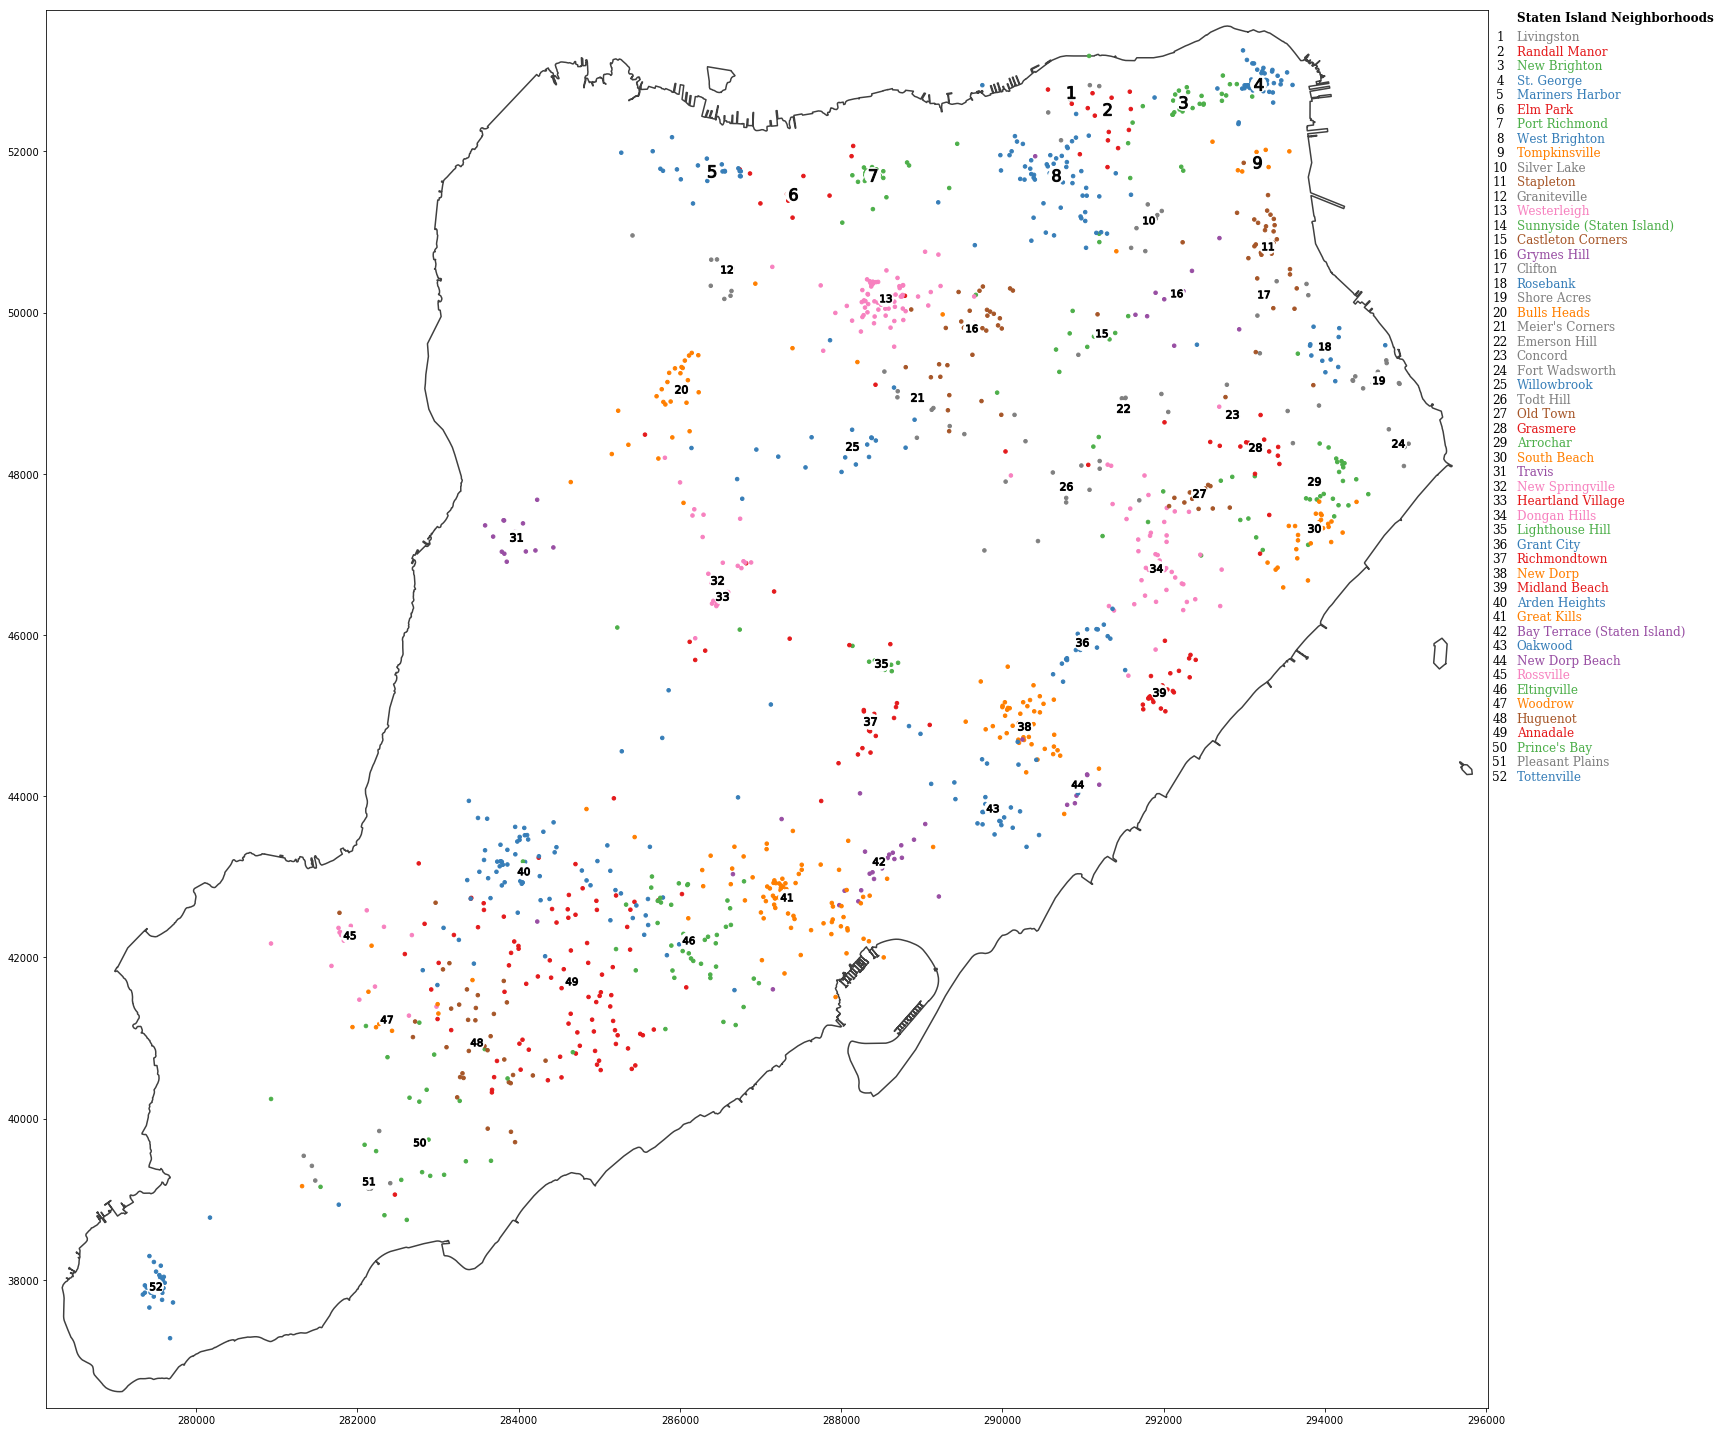

In [59]:
# Select just Staten Island as a basemap shape
nyc = nyc[nyc['BoroName'] == 'Staten Island']

# Now get the polygon exteriors that I want to map
cnt =0
lines = []
for i in list(nyc['geometry'].boundary)[0].geoms:
    lines.append(i)
    cnt+=1

# Let's try mapping all of the centroids of each neighbourhood.
fig, ax = plt.subplots(1,figsize=(27,20))

staten = ny_nhoods[ny_nhoods['BoroName']=='Staten Island']

centroids = []
for idx,row in staten.iterrows():
    centroids.append((str(row['nhood']),float(row['centroid'].x),float(row['centroid'].y)))
dt = [('nhood','a36'),('x', float), ('y', float)]
centroids = np.asarray(centroids,dtype=dt)

"""
red #e41a1c
blue #377eb8
green #4daf4a
purple #984ea3
orange #ff7f00
yellow #ffff33
brown #a65628
pink #f781bf

"""

# hard code a bunch of neighbourhood colours
colours = {'Annadale': '#e41a1c',
           'Arden Heights': '#377eb8',
           'Arrochar': '#4daf4a',
           'Bay Terrace (Staten Island)': '#984ea3',
           'Bulls Heads': '#ff7f00',
           'Castleton Corners': '#a65628',
           'Clifton': '0.5',
           'Concord': '0.5',
           'Dongan Hills': '#f781bf',
           'Elm Park': '#e41a1c',
           'Eltingville': '#4daf4a',
           'Emerson Hill': '0.5',
           'Fort Wadsworth': '0.5',
           'Graniteville': '0.5',
           'Grant City': '#377eb8',
           'Grasmere': '#e41a1c',
           'Great Kills': '#ff7f00',
           'Grymes Hill': '#984ea3',
           'Heartland Village': '#e41a1c',
           'Huguenot': '#a65628',
           'Lighthouse Hill': '#4daf4a',
           'Livingston': '0.5',
           'Mariners Harbor': '#377eb8',
           'Meier\'s Corners': '0.5',
           'Midland Beach': '#e41a1c',
           'New Brighton': '#4daf4a',
           'New Dorp': '#ff7f00',
           'New Dorp Beach': '#984ea3',
           'New Springville': '#f781bf',
           'Oakwood': '#377eb8',
           'Old Town': '#a65628',
           'Pleasant Plains': '0.5',
           'Port Richmond': '#4daf4a',
           'Prince\'s Bay': '#4daf4a',
           'Randall Manor': '#e41a1c',
           'Richmondtown': '#e41a1c',
           'Rosebank': '#377eb8',
           'Rossville': '#f781bf',
           'Shore Acres': '0.5',
           'Silver Lake': '0.5',
           'South Beach': '#ff7f00',
           'St. George': '#377eb8',
           'Stapleton': '#a65628',
           'Sunnyside (Staten Island)': '#4daf4a',
           'Todt Hill': '0.5',
           'Tompkinsville': '#ff7f00',
           'Tottenville': '#377eb8',
           'Travis': '#984ea3',
           'West Brighton': '#377eb8',
           'Westerleigh': '#f781bf',
           'Willowbrook': '#377eb8',
           'Woodrow': '#ff7f00'
          }

centroids = pd.DataFrame(dict(x=centroids['x'], y=centroids['y'], nhood=centroids['nhood']))
ax.scatter(centroids['x'],centroids['y'],color=centroids['nhood'].apply(lambda x: colours[x]),marker='.',s=50,zorder=10)

extent ={'minx':1000000,'maxx':0,'miny':1000000,'maxy':0}
for i in lines:
        x,y = i.xy
        ax.plot(x,y,c='0.25',zorder=1)
        minx,miny,maxx,maxy = i.bounds
        if minx < extent['minx']:
            extent['minx'] = minx
        if miny < extent['miny']:
            extent['miny'] = miny
        if maxx > extent['maxx']:
            extent['maxx'] = maxx
        if maxy > extent['maxy']:
            extent['maxy'] = maxy
plt.xlim([extent['minx']-200,extent['maxx']+200])
plt.ylim([extent['miny']-200,extent['maxy']+200])
ax.set_aspect('equal')
plt.tight_layout()

# Add x and y values as columns to median centres dataframe
n_centroids["x"] = n_centroids.centroid.map(lambda p: p.x)
n_centroids["y"] = n_centroids.centroid.map(lambda p: p.y)
# Create new 'labels' dataframe for manhattan, ordered by northerlyness
labels = n_centroids[n_centroids['BoroName'] == 'Staten Island'].sort_values('y',ascending=False)
labels['order'] = [4,1,3,2,9,5,8,7,6,10,11,12,16,17,13,16,15,18,19,20,21,22,23,24,25,28,29,26,27,30,31,34,32,33,36,35,39,37,38,
                   44,43,42,40,41,45,46,49,47,48,50,51,52]
labels = labels.sort_values('order',ascending=True)
texts = labels.sort_values('order',ascending=False)

for i,data in labels.iterrows():
    # Draw White circle
    ax.scatter(data['x'], data['y'],marker='o', c="white", alpha=1, s=250,zorder = 100)
    # Add id number
    ax.scatter(data['x'], data['y'], marker='$%d$' % int(data['order']),c='k', alpha=1, s=150, zorder = 101)
texty = 44200
for idx,label in texts.iterrows():
    font = {'family': 'serif','color': colours[str(label['neighborhood'])] ,'weight': 'normal','size': 12}
    plt.text(extent['maxx']+550,texty,str(label['neighborhood']),fontdict=font)
    texty += 180
tcount =52
texty = 44200
for idx, label in labels.iterrows():
    font = {'family': 'serif','color':'k' ,'weight': 'normal','size': 12}
    if tcount > 9:
        plt.text(extent['maxx']+250,texty,tcount,fontdict=font)
    else:
        plt.text(extent['maxx']+300,texty,tcount,fontdict=font)
    texty += 180
    tcount -=1
plt.text(extent['maxx']+550,53610,"Staten Island Neighborhoods",fontdict={'family': 'serif','color': 'k' ,'weight': 'heavy','size': 12})

plt.savefig('Staten_Island_Centroids_Legend_Outside.png',dpi=300)

## Bronx Neighborhoods

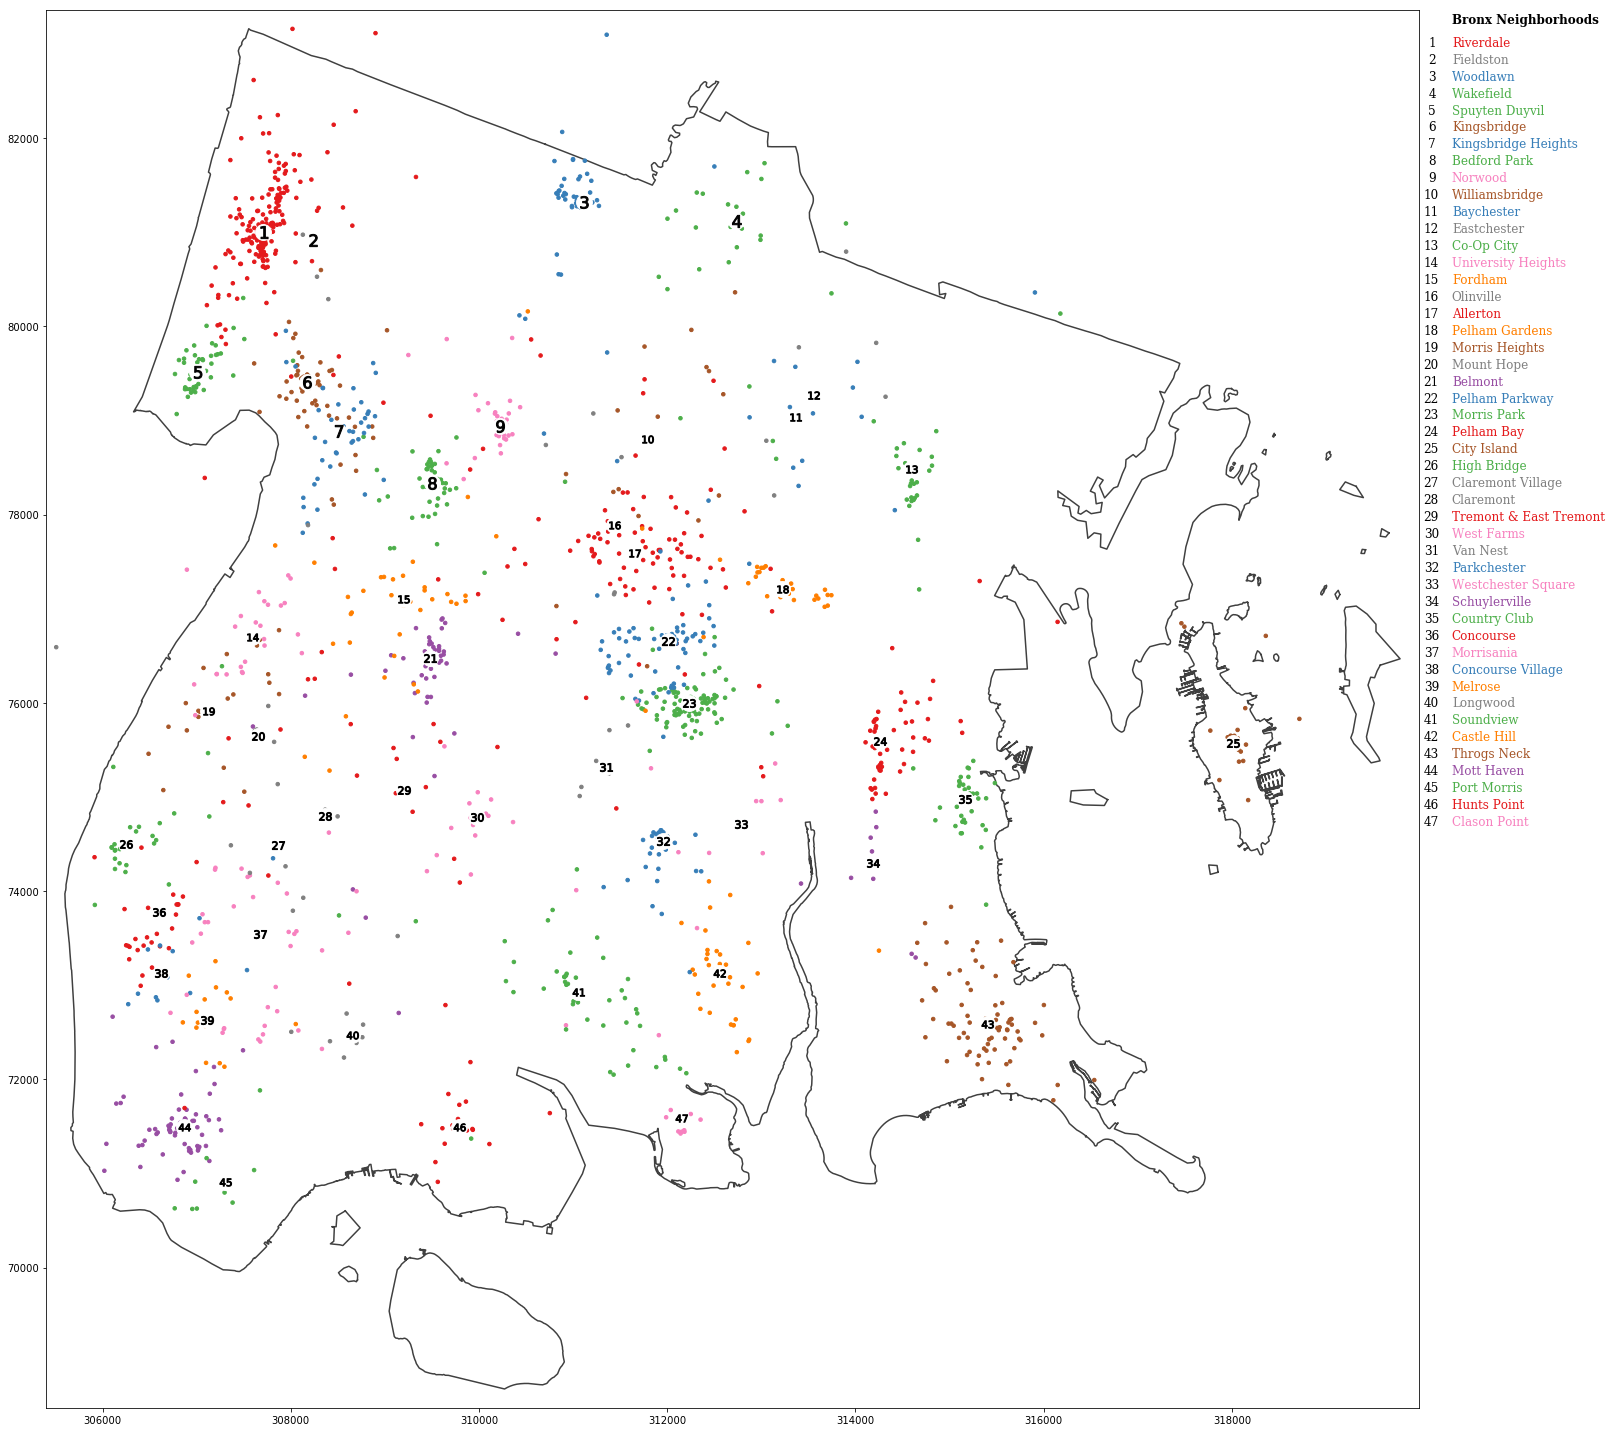

In [79]:
# New York City borough boundaries.
nyc = gpd.read_file(r'C:\Users\djl543\OneDrive\Draw-Your-Neighborhood-master\NYC.shp')

# Project to EPSG:32118 - New York Long Island, NAD83-based projection in metres.
nyc = nyc.to_crs({'init':'epsg:32118'})

# Select just manhattan as a basemap shape
nyc = nyc[nyc['BoroName'] == 'Bronx']

# Now get the polygon exteriors that I want to map
cnt =0
lines = []
for i in list(nyc['geometry'].boundary)[0].geoms:
    lines.append(i)
    cnt+=1

# Let's try mapping all of the centroids of each neighbourhood.
fig, ax = plt.subplots(1,figsize=(26,20))

bronx = ny_nhoods[ny_nhoods['BoroName']=='Bronx']

centroids = []
for idx,row in bronx.iterrows():
    centroids.append((str(row['nhood']),float(row['centroid'].x),float(row['centroid'].y)))
dt = [('nhood','a36'),('x', float), ('y', float)]
centroids = np.asarray(centroids,dtype=dt)

"""
red #e41a1c
blue #377eb8
green #4daf4a
purple #984ea3
orange #ff7f00
yellow #ffff33
brown #a65628
pink #f781bf

"""

# hard code a bunch of neighbourhood colours
colours = {'Allerton': '#e41a1c',
           'Baychester': '#377eb8',
           'Bedford Park ': '#4daf4a',
           'Belmont': '#984ea3',
           'Castle Hill': '#ff7f00',
           'City Island': '#a65628',
           'Claremont': '0.5',
           'Claremont Village': '0.5',
           'Clason Point': '#f781bf',
           'Co-Op City': '#4daf4a',
           'Concourse': '#e41a1c',
           'Concourse Village': '#377eb8',
           'Country Club': '#4daf4a',
           'Eastchester': '0.5',
           'Fieldston': '0.5',
           'Fordham': '#ff7f00',
           'High Bridge': '#4daf4a',
           'Hunts Point': '#e41a1c',
           'Kingsbridge': '#a65628',
           'Kingsbridge Heights': '#377eb8',
           'Longwood': '0.5',
           'Melrose': '#ff7f00',
           'Morris Heights': '#a65628',
           'Morris Park': '#4daf4a',
           'Morrisania': '#f781bf',
           'Mott Haven': '#984ea3',
           'Mount Hope': '0.5',
           'Norwood': '#f781bf',
           'Olinville': '0.5',
           'Parkchester': '#377eb8',
           'Pelham Bay': '#e41a1c',
           'Pelham Gardens': '#ff7f00',
           'Pelham Parkway': '#377eb8',
           'Port Morris': '#4daf4a',
           'Riverdale': '#e41a1c',
           'Schuylerville': '#984ea3',
           'Soundview': '#4daf4a',
           'Spuyten Duyvil': '#4daf4a',
           'Throgs Neck': '#a65628',
           'Tremont & East Tremont': '#e41a1c',
           'University Heights': '#f781bf',
           'Van Nest': '0.5',
           'Wakefield': '#4daf4a',
           'West Farms': '#f781bf',
           'Westchester Square': '#f781bf',
           'Williamsbridge': '#a65628',
           'Woodlawn': '#377eb8'
          }

centroids = pd.DataFrame(dict(x=centroids['x'], y=centroids['y'], nhood=centroids['nhood']))
ax.scatter(centroids['x'],centroids['y'],color=centroids['nhood'].apply(lambda x: colours[x]),marker='.',s=50,zorder=10)

extent ={'minx':1000000,'maxx':0,'miny':1000000,'maxy':0}
for i in lines:
        x,y = i.xy
        ax.plot(x,y,c='0.25',zorder=1)
        minx,miny,maxx,maxy = i.bounds
        if minx < extent['minx']:
            extent['minx'] = minx
        if miny < extent['miny']:
            extent['miny'] = miny
        if maxx > extent['maxx']:
            extent['maxx'] = maxx
        if maxy > extent['maxy']:
            extent['maxy'] = maxy
plt.xlim([extent['minx']-200,extent['maxx']+200])
plt.ylim([extent['miny']-200,extent['maxy']+200])
ax.set_aspect('equal')
plt.tight_layout()

# Add x and y values as columns to median centres dataframe
n_centroids["x"] = n_centroids.centroid.map(lambda p: p.x)
n_centroids["y"] = n_centroids.centroid.map(lambda p: p.y)
# Create new 'labels' dataframe for manhattan, ordered by northerlyness
labels = n_centroids[n_centroids['BoroName'] == 'Bronx']
labels = labels.sort_values('y',ascending=False)
labels['order'] = [3,4,1,2,5,6,12,11,9,7,10,13,8,16,17,18,15,14,22,21,23,19,20,24,25,
                   31,29,35,28,30,33,32,26,27,34,36,37,42,38,41,39,43,40,47,44,46,45]
labels = labels.sort_values('order',ascending=True)
texts = labels.sort_values('order',ascending=False)

for i,data in labels.iterrows():
    # Draw White circle
    ax.scatter(data['x'], data['y'],marker='o', c="white", alpha=1, s=250,zorder = 100)
    # Add id number
    ax.scatter(data['x'], data['y'], marker='$%d$' % int(data['order']),c='k', alpha=1, s=150, zorder = 101)

texty = 74700
for idx,label in texts.iterrows():
    font = {'family': 'serif','color': colours[str(label['neighborhood'])] ,'weight': 'normal','size': 12}
    plt.text(extent['maxx']+550,texty,str(label['neighborhood']),fontdict=font)
    texty += 180
tcount =47
texty = 74700
for idx, label in labels.iterrows():
    font = {'family': 'serif','color':'k' ,'weight': 'normal','size': 12}
    if tcount > 9:
        plt.text(extent['maxx']+250,texty,tcount,fontdict=font)
    else:
        plt.text(extent['maxx']+300,texty,tcount,fontdict=font)
    texty += 180
    tcount -=1
plt.text(extent['maxx']+550,83220,"Bronx Neighborhoods",fontdict={'family': 'serif','color': 'k' ,'weight': 'heavy','size': 12})
plt.savefig('Bronx_Centroids_Legend_Outside.png',dpi=300)

## Brooklyn Neighborhoods

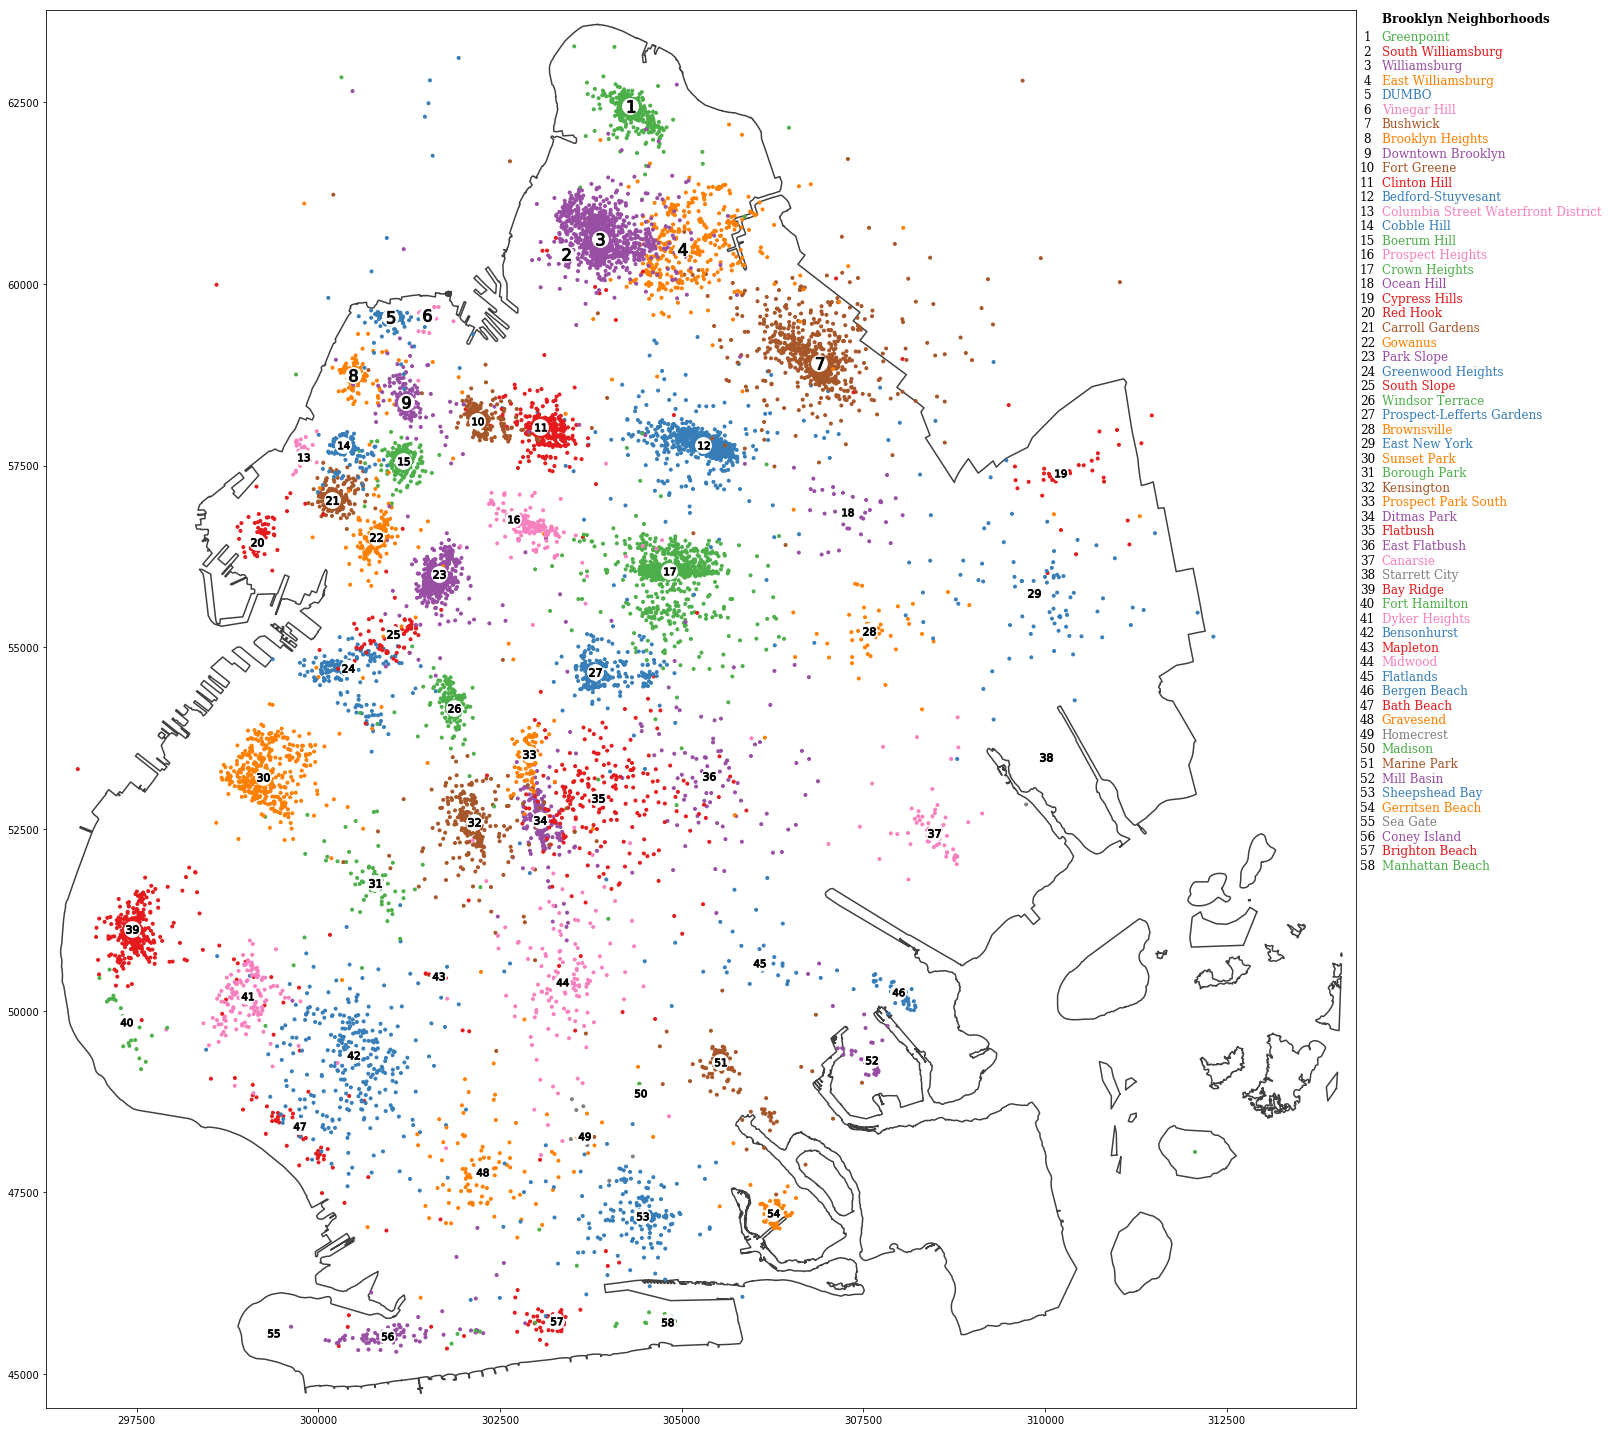

In [98]:
# New York City borough boundaries.
nyc = gpd.read_file(r'C:\Users\djl543\OneDrive\Draw-Your-Neighborhood-master\NYC.shp')

# Project to EPSG:32118 - New York Long Island, NAD83-based projection in metres.
nyc = nyc.to_crs({'init':'epsg:32118'})

# Select just manhattan as a basemap shape
nyc = nyc[nyc['BoroName'] == 'Brooklyn']

# Now get the polygon exteriors that I want to map
cnt =0
lines = []
for i in list(nyc['geometry'].boundary)[0].geoms:
    lines.append(i)
    cnt+=1

# Let's try mapping all of the centroids of each neighbourhood.
fig, ax = plt.subplots(1,figsize=(26,20))

brooklyn = ny_nhoods[ny_nhoods['BoroName']=='Brooklyn']

centroids = []
for idx,row in brooklyn.iterrows():
    centroids.append((str(row['nhood']),float(row['centroid'].x),float(row['centroid'].y)))
dt = [('nhood','a36'),('x', float), ('y', float)]
centroids = np.asarray(centroids,dtype=dt)

# hard code a bunch of neighbourhood colours
colours = {'Bath Beach': '#e41a1c',
           'Bay Ridge': '#e41a1c',
           'Bedford-Stuyvesant': '#377eb8',
           'Bensonhurst': '#377eb8',
           'Bergen Beach': '#377eb8',
           'Boerum Hill': '#4daf4a',
           'Borough Park': '#4daf4a',
           'Brighton Beach': '#e41a1c',
           'Brooklyn Heights': '#ff7f00',
           'Brownsville': '#ff7f00',
           'Bushwick': '#a65628',
           'Canarsie': '#f781bf',
           'Carroll Gardens': '#a65628',
           'Clinton Hill': '#e41a1c',
           'Cobble Hill': '#377eb8',
           'Columbia Street Waterfront District': '#f781bf',
           'Coney Island': '#984ea3',
           'Crown Heights': '#4daf4a',
           'Cypress Hills': '#e41a1c',
           'DUMBO': '#377eb8',
           'Ditmas Park': '#984ea3',
           'Downtown Brooklyn': '#984ea3',
           'Dyker Heights': '#f781bf',
           'East Flatbush': '#984ea3',
           'East New York': '#377eb8',
           'East Williamsburg': '#ff7f00',
           'Flatbush': '#e41a1c',
           'Flatlands': '#377eb8',
           'Fort Greene': '#a65628',
           'Fort Hamilton': '#4daf4a',
           'Gerritsen Beach': '#ff7f00',
           'Gowanus': '#ff7f00',
           'Gravesend': '#ff7f00',
           'Greenpoint': '#4daf4a',
           'Greenwood Heights': '#377eb8',
           'Homecrest': '0.5',
           'Kensington': '#a65628',
           'Madison': '#4daf4a',
           'Manhattan Beach': '#4daf4a',
           'Mapleton': '#e41a1c',
           'Marine Park': '#a65628',
           'Midwood': '#f781bf',
           'Mill Basin': '#984ea3',
           'Ocean Hill': '#984ea3',
           'Park Slope': '#984ea3',
           'Prospect Heights': '#f781bf',
           'Prospect Park South': '#ff7f00',
           'Prospect-Lefferts Gardens': '#377eb8',
           'Red Hook': '#e41a1c',
           'Sea Gate': '0.5',
           'Sheepshead Bay': '#377eb8',
           'South Slope ': '#e41a1c',
           'South Williamsburg': '#e41a1c',
           'Starrett City': '0.5',
           'Sunset Park': '#ff7f00',
           'Vinegar Hill': '#f781bf',
           'Williamsburg': '#984ea3',
           'Windsor Terrace': '#4daf4a'}

centroids = pd.DataFrame(dict(x=centroids['x'], y=centroids['y'], nhood=centroids['nhood']))
ax.scatter(centroids['x'],centroids['y'],color=centroids['nhood'].apply(lambda x: colours[x]),marker='.',zorder=10)

# Add x and y values as columns to median centres dataframe
n_centroids["x"] = n_centroids.centroid.map(lambda p: p.x)
n_centroids["y"] = n_centroids.centroid.map(lambda p: p.y)
# Create new 'labels' dataframe for manhattan, ordered by northerlyness
labels = n_centroids[n_centroids['BoroName'] == 'Brooklyn'].sort_values('y',ascending=False)
labels['order'] = [1,3,4,2,6,5,7,8,9,10,11,12,14,13,15,19,21,18,16,22,20,17,23,29,28,25,24,27,26,33,38,36,30,35,34,32,37,31,39,
                  45,43,44,46,41,40,42,52,51,50,47,49,48,54,53,57,58,55,56]
labels = labels.sort_values('order',ascending=True)
texts = labels.sort_values('order',ascending=False)


for i,data in labels.iterrows():
    # Draw White circle
    ax.scatter(data['x'], data['y'],marker='o', c="white", alpha=1, s=250,zorder = 100)
    # Add id number
    ax.scatter(data['x'], data['y'], marker='$%d$' % int(data['order']),c='k', alpha=1, s=150, zorder = 101)


extent ={'minx':1000000,'maxx':0,'miny':1000000,'maxy':0}
for i in lines:
        x,y = i.xy
        ax.plot(x,y,c='0.25',zorder=1)
        minx,miny,maxx,maxy = i.bounds
        if minx < extent['minx']:
            extent['minx'] = minx
        if miny < extent['miny']:
            extent['miny'] = miny
        if maxx > extent['maxx']:
            extent['maxx'] = maxx
        if maxy > extent['maxy']:
            extent['maxy'] = maxy
plt.xlim([extent['minx']-200,extent['maxx']+200])
plt.ylim([extent['miny']-200,extent['maxy']+200])
ax.set_aspect('equal')
plt.tight_layout()
texty = 51950
for idx,label in texts.iterrows():
    font = {'family': 'serif','color': colours[str(label['neighborhood'])] ,'weight': 'normal','size': 12}
    plt.text(extent['maxx']+550,texty,str(label['neighborhood']),fontdict=font)
    texty += 200
tcount =58
texty = 51950
for idx, label in labels.iterrows():
    font = {'family': 'serif','color':'k' ,'weight': 'normal','size': 12}
    if tcount > 9:
        plt.text(extent['maxx']+250,texty,tcount,fontdict=font)
    else:
        plt.text(extent['maxx']+300,texty,tcount,fontdict=font)
    texty += 200
    tcount -=1
plt.text(extent['maxx']+550,63600,"Brooklyn Neighborhoods",fontdict={'family': 'serif','color': 'k' ,'weight': 'heavy','size': 12})
plt.savefig('Brooklyn_Centroids_Legend_Outside.png',dpi=300)


## Queens Neighborhoods

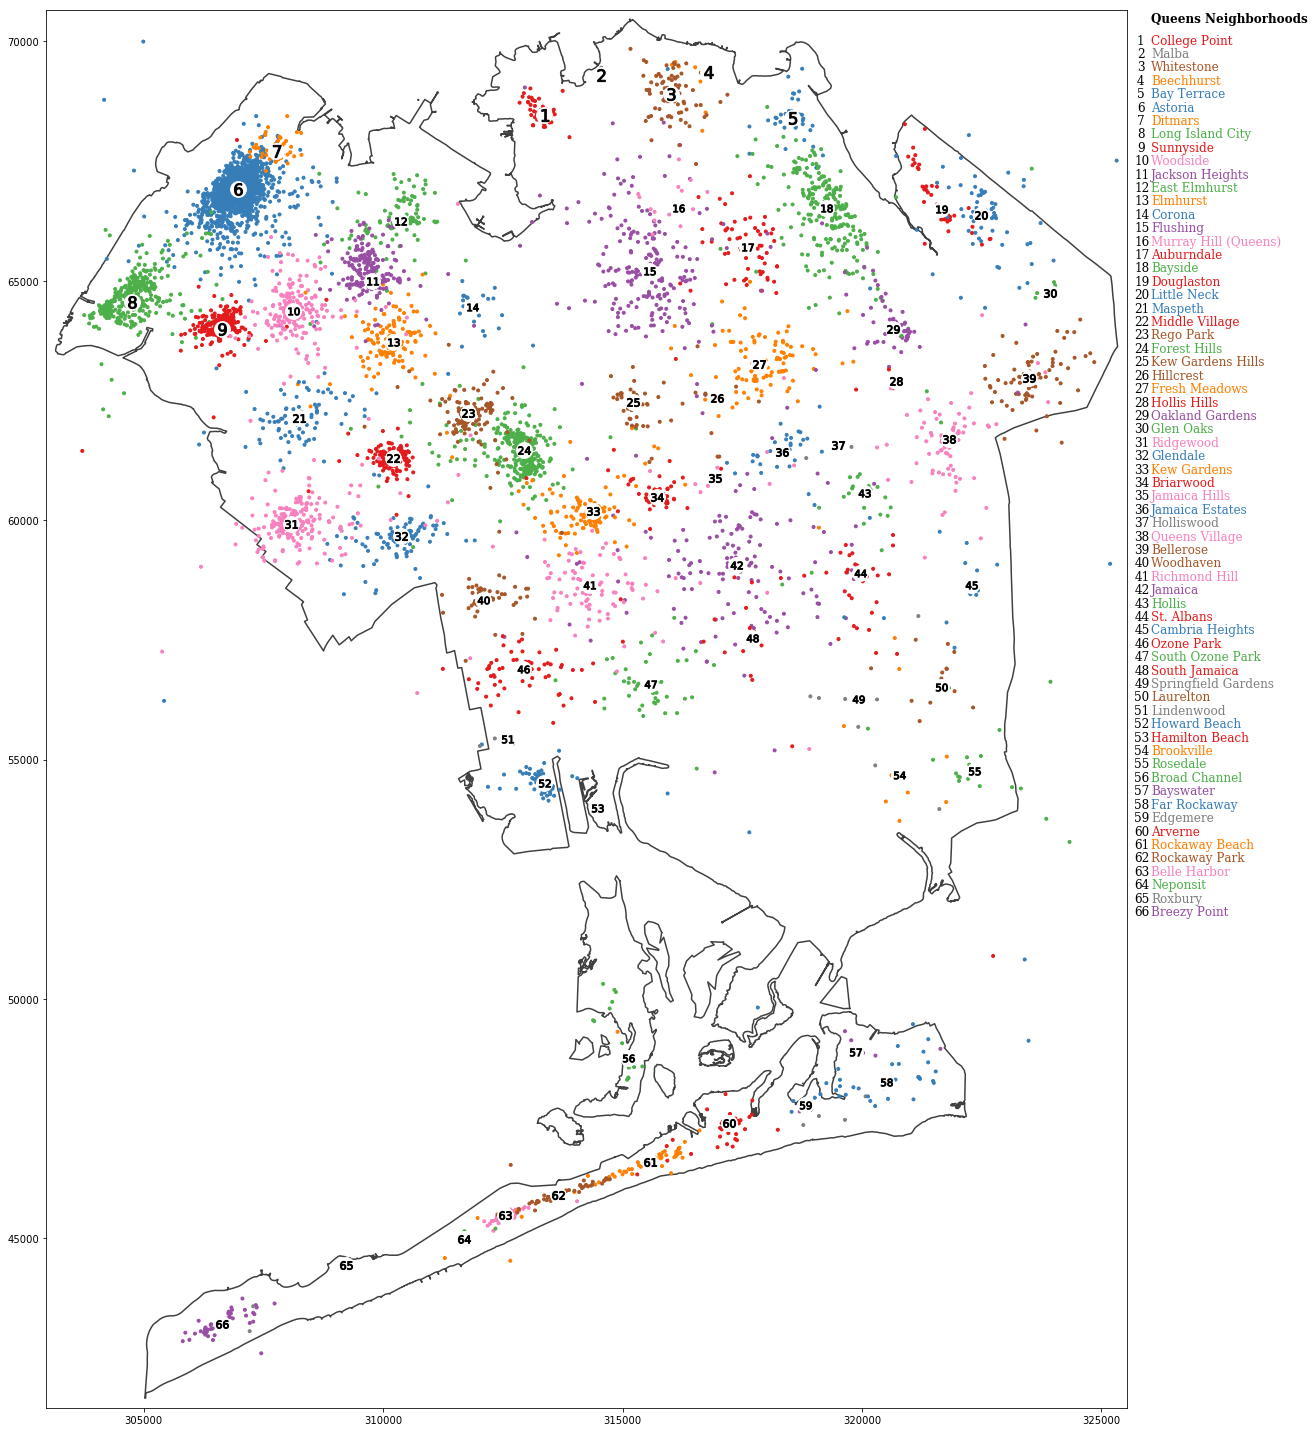

In [140]:
# New York City borough boundaries.
nyc = gpd.read_file(r'C:\Users\djl543\OneDrive\Draw-Your-Neighborhood-master\NYC.shp')

# Project to EPSG:32118 - New York Long Island, NAD83-based projection in metres.
nyc = nyc.to_crs({'init':'epsg:32118'})

# Select just manhattan as a basemap shape
nyc = nyc[nyc['BoroName'] == 'Queens']

# Now get the polygon exteriors that I want to map
cnt =0
lines = []
for i in list(nyc['geometry'].boundary)[0].geoms:
    lines.append(i)
    cnt+=1

# Let's try mapping all of the centroids of each neighbourhood.
fig, ax = plt.subplots(1,figsize=(26,20))

queens = ny_nhoods[ny_nhoods['BoroName']=='Queens']

centroids = []
for idx,row in queens.iterrows():
    centroids.append((str(row['nhood']),float(row['centroid'].x),float(row['centroid'].y)))
dt = [('nhood','a36'),('x', float), ('y', float)]
centroids = np.asarray(centroids,dtype=dt)

"""
red #e41a1c
blue #377eb8
green #4daf4a
purple #984ea3
orange #ff7f00
yellow #ffff33
brown #a65628
pink #f781bf

"""

# hard code a bunch of neighbourhood colours
colours = {'Arverne':'#e41a1c',
           'Astoria':'#377eb8',
           'Auburndale':'#e41a1c',
           'Bay Terrace':'#377eb8',
           'Bayside':'#4daf4a',
           'Bayswater':'#984ea3',
           'Beechhurst':'#ff7f00',
           'Belle Harbor':'#f781bf',
           'Bellerose':'#a65628',
           'Breezy Point':'#984ea3',
           'Briarwood':'#e41a1c',
           'Broad Channel':'#4daf4a',
           'Brookville':'#ff7f00',
           'Cambria Heights':'#377eb8',
           'College Point':'#e41a1c',
           'Corona':'#377eb8',
           'Ditmars':'#ff7f00',
           'Douglaston':'#e41a1c',
           'East Elmhurst':'#4daf4a',
           'Edgemere':'0.5',
           'Elmhurst':'#ff7f00',
           'Far Rockaway':'#377eb8',
           'Flushing':'#984ea3',
           'Forest Hills':'#4daf4a',
           'Fresh Meadows':'#ff7f00',
           'Glendale':'#377eb8',
           'Glen Oaks': '#4daf4a',
           'Hamilton Beach':'#e41a1c',
           'Hillcrest':'#a65628',
           'Hollis':'#4daf4a',
           'Hollis Hills': '#e41a1c',
           'Holliswood':'0.5',
           'Howard Beach':'#377eb8',
           'Jackson Heights':'#984ea3',
           'Jamaica':'#984ea3',
           'Jamaica Estates':'#377eb8',
           'Jamaica Hills':'#f781bf',
           'Kew Gardens':'#ff7f00',
           'Kew Gardens Hills':'#a65628',
           'Laurelton':'#a65628',
           'Lindenwood':'0.5',
           'Little Neck':'#377eb8',
           'Long Island City':'#4daf4a',
           'Malba':'0.5',
           'Maspeth':'#377eb8',
           'Middle Village':'#e41a1c',
           'Murray Hill (Queens)':'#f781bf',
           'Neponsit':'#4daf4a',
           'Oakland Gardens':'#984ea3',
           'Ozone Park':'#e41a1c',
           'Queens Village':'#f781bf',
           'Rego Park':'#a65628',
           'Richmond Hill':'#f781bf',
           'Ridgewood':'#f781bf',
           'Rockaway Beach':'#ff7f00',
           'Rockaway Park':'#a65628',
           'Rosedale':'#4daf4a',
           'Roxbury':'0.5',
           'South Jamaica':'#e41a1c',
           'South Ozone Park':'#4daf4a',
           'Springfield Gardens':'0.5',
           'St. Albans':'#e41a1c',
           'Sunnyside':'#e41a1c',
           'Whitestone':'#a65628',
           'Woodhaven':'#a65628',
           'Woodside':'#f781bf'
          }

centroids = pd.DataFrame(dict(x=centroids['x'], y=centroids['y'], nhood=centroids['nhood']))
ax.scatter(centroids['x'],centroids['y'],color=centroids['nhood'].apply(lambda x: colours[x]),marker='.',zorder=10)

extent ={'minx':1000000,'maxx':0,'miny':1000000,'maxy':0}
for i in lines:
        x,y = i.xy
        ax.plot(x,y,c='0.25',zorder=1)
        minx,miny,maxx,maxy = i.bounds
        if minx < extent['minx']:
            extent['minx'] = minx
        if miny < extent['miny']:
            extent['miny'] = miny
        if maxx > extent['maxx']:
            extent['maxx'] = maxx
        if maxy > extent['maxy']:
            extent['maxy'] = maxy
plt.xlim([extent['minx']-200,extent['maxx']+200])
plt.ylim([extent['miny']-200,extent['maxy']+200])
ax.set_aspect('equal')
plt.tight_layout()

# Add x and y values as columns to median centres dataframe
n_centroids["x"] = n_centroids.centroid.map(lambda p: p.x)
n_centroids["y"] = n_centroids.centroid.map(lambda p: p.y)
# Create new 'labels' dataframe for manhattan, ordered by northerlyness
labels = n_centroids[n_centroids['BoroName'] == 'Queens'].sort_values('y',ascending=False)
labels['order'] = [4, 2, 3, 1, 5, 7, 6, 16, 18, 19, 20, 12, 17, 15, 11, 30, 8, 14, 10, 29, 9, 13, 
                   27, 39, 28, 26, 25, 23, 21, 38, 37, 24, 36, 22, 35, 43, 34, 33, 31, 32, 42, 44, 41, 
                   45, 40, 48, 46, 47, 50, 49, 51, 55, 54, 52, 53, 57, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66]
labels = labels.sort_values('order',ascending=True)
texts = labels.sort_values('order',ascending=False)

for i,data in labels.iterrows():
    # Draw White circle
    ax.scatter(data['x'], data['y'],marker='o', c="white", alpha=1, s=250,zorder = 100)
    # Add id number
    ax.scatter(data['x'], data['y'], marker='$%d$' % int(data['order']),c='k', alpha=1, s=150, zorder = 101)

texty = 51750
for idx,label in texts.iterrows():
    font = {'family': 'serif','color': colours[str(label['neighborhood'])] ,'weight': 'normal','size': 12}
    plt.text(extent['maxx']+700,texty,str(label['neighborhood']),fontdict=font)
    texty += 280
tcount =66
texty = 51750
for idx, label in labels.iterrows():
    font = {'family': 'serif','color':'k' ,'weight': 'normal','size': 12}
    if tcount > 9:
        plt.text(extent['maxx']+350,texty,tcount,fontdict=font)
    else:
        plt.text(extent['maxx']+400,texty,tcount,fontdict=font)
    texty += 280
    tcount -=1
plt.text(extent['maxx']+700,70400,"Queens Neighborhoods",fontdict={'family': 'serif','color': 'k' ,'weight': 'heavy','size': 12})
plt.savefig('Queens_Centroids_Legend_Outside.png',dpi=300)